**MASK WEAR DETECTION WITH LOGISTIC REGRESSION :**

In [1]:
from torch.utils.data import DataLoader
import os
import cv2
import random

class DataSet :

    def __init__(self,root,label):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        self.ROOT = root
        self.images = read_images(root)
        self.label = torch.from_numpy(np.array(label))
        #self.labels = read_labels(labels)

    def __len__(self):
        """return number of elements in our dataset"""
        
        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        img = self.images[idx]
        label = self.label[idx]

        return img, label

In [32]:
import torch
import numpy as np

def read_images(root) :
        '''load all the images from a folder'''
        images = []
        for filename in os.listdir(root) :
            '''
            Python method listdir() returns a list containing the names of the 
            entries in the directory given by path. The list is in arbitrary order. 
            It does not include the special entries '.' and '..' even if they are 
            present in the directory.'''
            img = cv2.imread(os.path.join(root,filename),cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(os.path.join(root,filename))
            if img is not None:
                #img = img[:,:,::-1]/255 # To shuffle the color channels form BGR to RGB and /255 to normalize
                #img = np.dot(img[...,:3], [0.299, 0.587, 0.144])
                img = img/255 # To normalize
                images.append(img)
        return torch.from_numpy(np.array(images))

ds_uwm = DataSet('Um_200',[0 for k in range(200)]) # 200 images in the file
ds_wm = DataSet("Wm_200",[1 for k in range(200)]) # 200 images in the file

Let's display the size of the datasets :

In [33]:
print("Worn Mask Dataset Length : {}\n".format(len(ds_wm)))
print("Unworn Mask Dataset Length : {}".format(len(ds_uwm)))

Worn Mask Dataset Length : 200

Unworn Mask Dataset Length : 200


Let's show the 6th element of the unworn mask dataset :

tensor([[0.1098, 0.1098, 0.1176,  ..., 0.5490, 0.5490, 0.5529],
        [0.1255, 0.1216, 0.1333,  ..., 0.5569, 0.5569, 0.5529],
        [0.1176, 0.1294, 0.1412,  ..., 0.5686, 0.5647, 0.5608],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 0.2706, 0.2706, 0.2588],
        [1.0000, 1.0000, 1.0000,  ..., 0.2706, 0.2627, 0.2549],
        [1.0000, 1.0000, 1.0000,  ..., 0.2706, 0.2549, 0.2588]],
       dtype=torch.float64) tensor(0, dtype=torch.int32)

Type of the image : <class 'torch.Tensor'>

Shape of the image : torch.Size([1024, 1024])


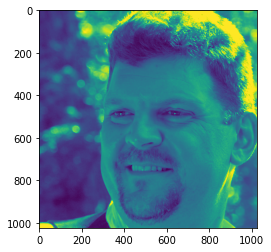

In [34]:
import matplotlib.pyplot as plt
img, label = ds_uwm[5]
print(img,label)
plt.imshow(img)
print("\nType of the image : {}\n".format(type(img)))
print("Shape of the image : {}".format(img.shape))

# Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Testing set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [35]:
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

train_ds_wm, val_ds_wm = random_split(ds_wm, [160, 40])

train_ds_uwm, val_ds_uwm = random_split(ds_uwm, [160, 40])

train_ds = train_ds_uwm + train_ds_wm
val_ds = val_ds_uwm + val_ds_wm

print("Length of the training set : {}\n".format(len(train_ds)))
print("Length of the validation set = {}\n".format(len(val_ds)))

Length of the training set : 320

Length of the validation set = 80



Let's initialize the dataloader :

In [36]:
from torch.utils.data import DataLoader

# The most important argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. 
# PyTorch supports two different types of datasets:
#        - map-style datasets,
#        - iterable-style datasets"""

batch_size = 40

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# We set shuffle=True for the training dataloader, so that the batches generated in each epoch are different, and this 
# randomization helps generalize & speed up the training process. 
# On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle 
# the images.

Let's initialize the model :

In [37]:
import torch.nn as nn

input_size = 1024*1024
num_classes = 2

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [38]:
print("Display the shape of the model weights : {}\n".format(model.weight.shape))
print("Display all the model weights : {}\n".format(model.weight))

Display the shape of the model weights : torch.Size([2, 1048576])

Display all the model weights : Parameter containing:
tensor([[ 8.0737e-04,  6.4004e-04, -1.3052e-04,  ...,  3.2572e-05,
          2.5121e-04,  8.8907e-04],
        [ 9.1073e-04, -8.9928e-04,  3.3424e-04,  ..., -7.5798e-04,
         -3.0325e-04, -8.0743e-04]], requires_grad=True)



In [39]:
print("Display the shape of the model bias : {}\n".format(model.bias.shape))
print("Display all the model bias : {}\n".format(model.bias))

Display the shape of the model bias : torch.Size([2])

Display all the model bias : Parameter containing:
tensor([-0.0004, -0.0005], requires_grad=True)



Let's define our model, by extending the `nn.Module` class from PyTorch.

In [40]:
class MWDModel(nn.Module): # MWD for Mask Wear detection
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1024*1024)
        out = self.linear(xb)
        return out
    
model = MWDModel()

In [41]:
print("Shape of the model linear weights : {}\n".format(model.linear.weight.shape))
print("Shape of the model linear bias : {}\n".format(model.linear.bias.shape))
print("Display the model parameters : \n")
list(model.parameters())

Shape of the model linear weights : torch.Size([2, 1048576])

Shape of the model linear bias : torch.Size([2])

Display the model parameters : 



[Parameter containing:
 tensor([[-4.2234e-04, -2.3545e-05,  2.1064e-04,  ..., -8.4880e-04,
           6.8753e-04,  6.3916e-04],
         [-1.7350e-04, -1.4711e-04, -4.7360e-05,  ..., -7.6831e-04,
           6.6046e-04, -5.3063e-04]], requires_grad=True),
 Parameter containing:
 tensor([-0.0002, -0.0007], requires_grad=True)]

In [42]:
for images, labels in train_loader:
    outputs = model(images.float()) # FLOAT()
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

# When the error is RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1', you 
# would need to use the .float() function since it says Expected object of scalar type Float.

# Therefore, the solution is changing y_pred = model(X_trainTensor) to y_pred = model(X_trainTensor.float()).

# Likewise, when you get another error for loss = loss_fn(y_pred, y_trainTensor), you need y_trainTensor.long() since the 
# error message says Expected object of scalar type Long.

# You could also do model.double()'''

outputs.shape :  torch.Size([40, 2])
Sample outputs :
 tensor([[0.5558, 0.3056],
        [0.6800, 0.6371]])


In [43]:
import torch.nn.functional as F

In [44]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

print("Look at sample probabilities :")
print("Sample probabilities:\n", probs[:2].data)

Look at sample probabilities :
Sample probabilities:
 tensor([[0.5622, 0.4378],
        [0.5107, 0.4893]])


In [45]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0])
tensor([0.5622, 0.5107, 0.5133, 0.5123, 0.5728, 0.5952, 0.5464, 0.5214, 0.5326,
        0.5059, 0.5702, 0.5812, 0.5083, 0.5668, 0.5522, 0.5208, 0.5076, 0.5512,
        0.5096, 0.5723, 0.5152, 0.6180, 0.5709, 0.5060, 0.5726, 0.5299, 0.5171,
        0.5417, 0.5819, 0.5270, 0.5035, 0.5206, 0.5011, 0.5563, 0.5797, 0.5286,
        0.5377, 0.5182, 0.5144, 0.5289], grad_fn=<MaxBackward0>)


In [46]:
labels.long()

tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels.long()).item() / len(preds))

In [48]:
accuracy(outputs, labels.long())

tensor(0.5750)

In [49]:
loss_fn = F.cross_entropy

In [50]:
# Loss for current batch of data
loss = loss_fn(outputs, labels.long())
print(loss)
print(type(outputs))

tensor(0.6980, grad_fn=<NllLossBackward>)
<class 'torch.Tensor'>


In [51]:
class MWDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1024*1024)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images.float())                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.float())                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MWDModel()

In [52]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 0.7075667977333069, 'val_acc': 0.5}

In [54]:
history = fit(8, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 716.7672, val_acc: 0.5000
Epoch [1], val_loss: 787.5333, val_acc: 0.5000
Epoch [2], val_loss: 619.0690, val_acc: 0.5000
Epoch [3], val_loss: 489.7552, val_acc: 0.5000
Epoch [4], val_loss: 450.3442, val_acc: 0.5000
Epoch [5], val_loss: 121.0124, val_acc: 0.7125
Epoch [6], val_loss: 165.2190, val_acc: 0.6375
Epoch [7], val_loss: 178.3823, val_acc: 0.6375


In [57]:
history2 = fit(8, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 134.0125, val_acc: 0.7375
Epoch [1], val_loss: 546.3807, val_acc: 0.5000
Epoch [2], val_loss: 195.4131, val_acc: 0.6625
Epoch [3], val_loss: 699.9954, val_acc: 0.5000
Epoch [4], val_loss: 120.8145, val_acc: 0.7500
Epoch [5], val_loss: 84.1538, val_acc: 0.8250
Epoch [6], val_loss: 98.6160, val_acc: 0.8250
Epoch [7], val_loss: 86.9825, val_acc: 0.8250


In [58]:
history3 = fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 92.4417, val_acc: 0.7750
Epoch [1], val_loss: 353.8127, val_acc: 0.5250
Epoch [2], val_loss: 204.3353, val_acc: 0.6375
Epoch [3], val_loss: 74.9067, val_acc: 0.8500
Epoch [4], val_loss: 316.8612, val_acc: 0.5250
Epoch [5], val_loss: 183.5346, val_acc: 0.6875
Epoch [6], val_loss: 121.4992, val_acc: 0.7625
Epoch [7], val_loss: 69.3192, val_acc: 0.8500
Epoch [8], val_loss: 67.4186, val_acc: 0.8500
Epoch [9], val_loss: 84.5070, val_acc: 0.8375


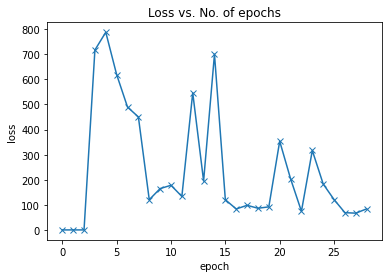

In [59]:
import matplotlib.pyplot as plt

history = [result0] + history + history2 + history3
loss = [result['val_loss'] for result in history]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

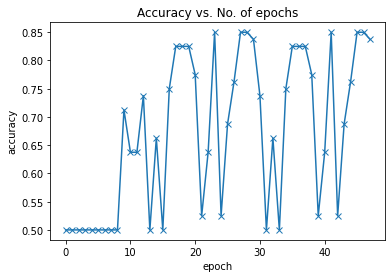

In [60]:

history = [result0] + history + history2 + history3
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [61]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [62]:
new_imgs = read_images("Individual_tests")

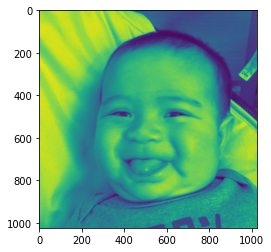

Predicted: 0


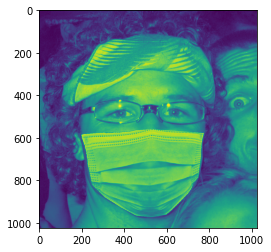

Predicted: 0


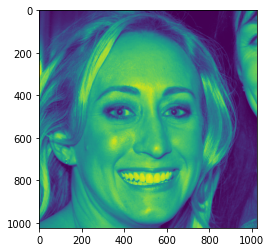

Predicted: 0


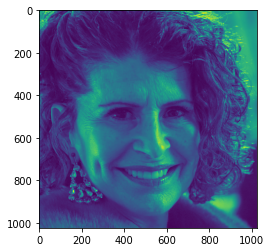

Predicted: 0


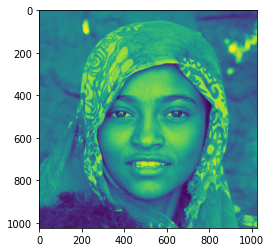

Predicted: 0


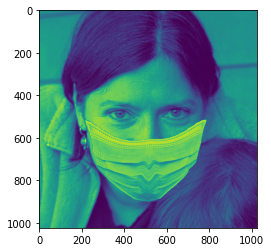

Predicted: 1


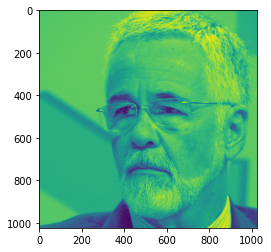

Predicted: 0


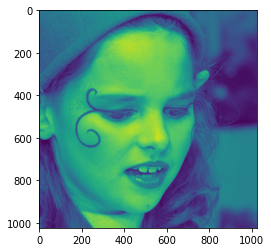

Predicted: 0


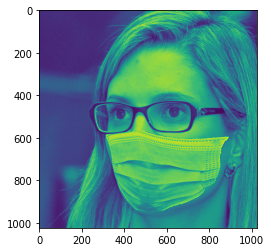

Predicted: 1


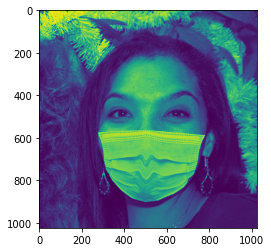

Predicted: 1


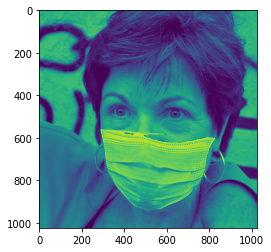

Predicted: 1


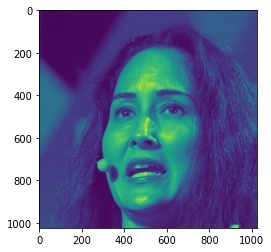

Predicted: 0


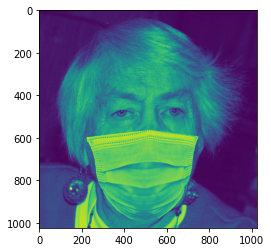

Predicted: 1


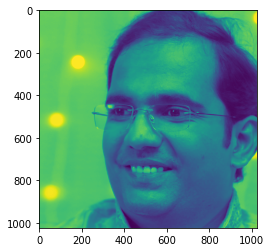

Predicted: 0


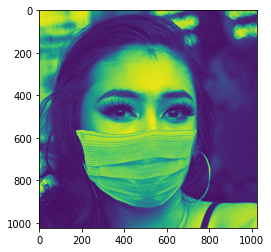

Predicted: 0


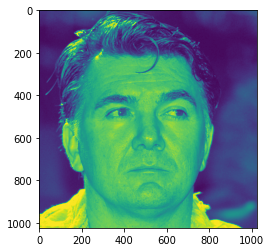

Predicted: 0


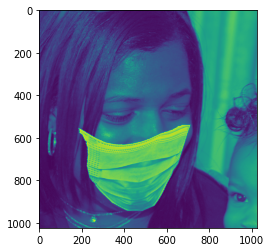

Predicted: 1


In [63]:
for i in range(len(new_imgs)) :
    plt.imshow(new_imgs[i])
    plt.show()
    print('Predicted:', predict_image(new_imgs[i].float(), model))

Let's try now with images of masked or unmasked people taken on the internet :

In [64]:
new_imgs_internet = read_images("Individual_tests_internet")

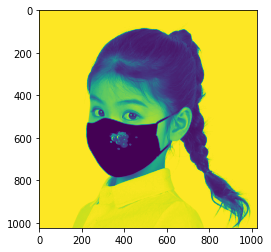

Predicted: 0


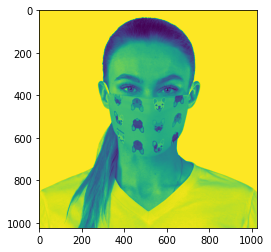

Predicted: 0


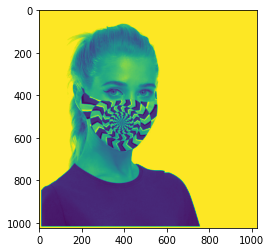

Predicted: 0


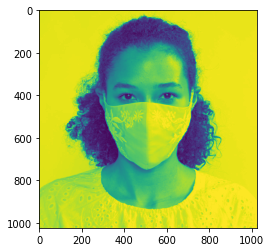

Predicted: 0


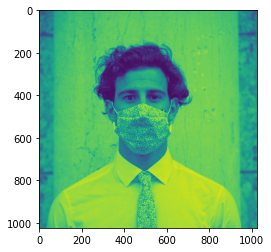

Predicted: 0


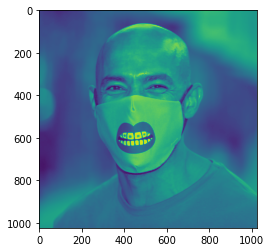

Predicted: 0


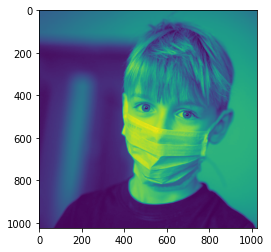

Predicted: 0


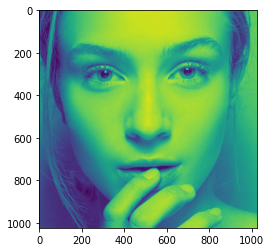

Predicted: 0


In [65]:
for i in range(len(new_imgs_internet)) :
    plt.imshow(new_imgs_internet[i])
    plt.show()
    print('Predicted:', predict_image(new_imgs_internet[i].float(), model))